<h1 align="center">AIND-CNC Spring Hackathon</h1>  
<h4 align="center"> May 14, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
    

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** This notebook shows how to access and analyze data from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) project established at the Allen Institute for Neural Dynamics. 

**Dataset:** Calcium activity was recorded from hundreds of cortical neurons in the mouse motor cortex while the animal learned and performed a Brain Computer Interface (BCI) task over several days. 
    
**Goal:** This tutorial will show you how to:  
    1. load and work with neuronal calcium activity data processed via suite2p 
    2. plot event-aligned neural activity traces 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">
Let's add a little more about the dataset - explain the task a little more and mention the photostim and spontaneous aspects. And the condition neuron. 
Need to adjust format to get the list for the goals.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [2]:
# General imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import os 
import re
import pandas as pd
from skimage import measure
from pathlib import Path

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

# Custom functions
from generate_epoch_table import generate_epoch_table

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The 'metadata.csv' in the '/data' folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| session_number    | behavior training session number   |

In [3]:
# Load csv as a Pandas DataFrame 
metadata = pd.read_csv('/data/metadata.csv', index_col = False) 

# Sort values by name and reindex 
metadata = metadata.sort_values(by = ['name']).reset_index(drop = True)
metadata[0:10]

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,e19d57eb-048c-49fb-a564-9f23b3205c3d,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,20.0
1,5c307543-bf11-4a82-bcdf-85f0886d41cb,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
2,0b6a3ab2-c50c-429a-9588-1e6992ded444,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
3,57178d7b-5c87-4376-933a-769eeabcdd19,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,23.0
4,d69eda23-6aa2-4904-80aa-53f44feb534c,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0
5,03073291-8f24-4293-bfea-c46a14f2910e,single-plane-ophys_740369_2025-01-24_21-18-11_...,740369,2025-01-24T20:08:49.286000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,25.0
6,1bb6534a-a7d8-4498-a12d-5dd628d7837d,single-plane-ophys_740369_2025-01-30_18-44-54_...,740369,2025-01-30T18:44:54.865000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,NaN,NaN
7,2b931997-865b-495a-86b5-c0188fef6c9d,single-plane-ophys_740369_2025-02-04_17-33-11_...,740369,2025-02-04T17:33:11.691000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_06,28.0
8,9dd6fc97-913c-4038-9e8c-759ea55fe905,single-plane-ophys_740369_2025-02-17_19-26-59_...,740369,2025-02-17T19:26:59.000999-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_07,32.0
9,db30abf5-90a9-4e3f-a927-a0a9657ba5b1,single-plane-ophys_754303_2025-01-22_18-22-38_...,754303,2025-01-22T16:59:35.618000-08:00,BCI single neuron stim,Camk2a-tTA/wt;TetO-jGCaMP8s-01/wt,pAAV-CaMKIIa-ChRmine-oScarlet-Kv2.1-WPRE - 7413,FOV_01,2.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This file was pre-generated by running the metadata python notebook attached to this capsule. More metadata was captured for each experimental session than what is shown here - you can access the full records by querying the AIND metadata database using `aind-data-access-api`. See the metadata python notebook for an example. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Organization 
    
The naming scheme for each raw data asset is as follows:
 > single-plane-ophys (data type) <br> 
   772414 (numerical id for the subject) <br> 
   2025-01-10T16:46:51.981999-08:00 (experiment date (%Y-%m-%d %H:%M:%S)) <br>
    
The /data folder contains a directory named for each experimental session that was processed through the optical physiology (ophys) pipeline (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25`). The pipeline runs the raw fluorescence data through suite2p and packages the ophys, behavior, and stimulus information into an Neurodata Without Borders (NWB) format. Each directory contains an NWB directory (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb`).
    
From the metadata table, we'll store the subject_id and date for a session of interest. 

In [29]:
idx = 19

subject_id = metadata.subject_id[idx] 
date = metadata.session_time[idx][0:10] # save just the year, month, and date

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">
    
If we're using an index, why not just get the asset name?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load Data 
    
These NWB files are stored in a cloud-friendly Zarr backend. We'll use the NWBZarrIO package from hdmf_zarr to load the files. 
    
We've written a helper function `load_nwb` that searches the /data folder for an NWB directory that matches a given subject_id and date, then loads using NWBZarrIO. 
    

In [5]:
def load_nwb(subject_id, date):
    """
    Searches the /data directory for a folder and subfolder containing the subject_id and date,
    and loads the corresponding NWB file.

    Parameters:
    - subject_id (str): Subject identifier to search for in directory names
    - date (str): Date string (e.g. '2023-05-09') to search for in directory names

    Returns:
    - nwbfile: Loaded NWBFile object if found, else None
    """

    # Create pattern for matching
    pattern = rf".*{subject_id}.*{date}.*"
    base_path = Path('/data')
    
    # Find matching first-level directories
    first_matches = [d for d in base_path.iterdir() 
                     if d.is_dir() and re.search(pattern, d.name)]
    
    if not first_matches:
        print(f"Directory matching subject_id={subject_id} and date={date} not found in /data.")
        return None
    
    first_dir = first_matches[0]
    print(f"Found first-level directory: {first_dir.name}")
    
    # Find matching second-level directories
    second_matches = [d for d in first_dir.iterdir() 
                      if d.is_dir() and re.search(pattern, d.name)]
    
    if not second_matches:
        print(f"No second-level directory matching subject_id={subject_id} and date={date} found.")
        return None
    
    nwb_path = second_matches[0]
    print(f"Found second-level directory: {nwb_path.name}")
    
    # Check if path exists and load NWB file
    try:
        with NWBZarrIO(str(nwb_path), 'r') as io:
            nwbfile = io.read()
            print('Loaded NWB file from:', nwb_path)
            return nwbfile
    except Exception as e:
        print(f'Error loading file from {nwb_path}: {e}')
        return None

In [30]:
nwbfile = load_nwb(subject_id, date)

Found first-level directory: single-plane-ophys_767715_2025-02-03_17-30-05_processed_2025-05-11_12-45-08
Found second-level directory: single-plane-ophys_767715_2025-02-03_17-30-05_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_767715_2025-02-03_17-30-05_processed_2025-05-11_12-45-08/single-plane-ophys_767715_2025-02-03_17-30-05_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [7]:
nwb2widget(nwbfile) 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot Calcium Activity Traces for Select ROIs 
    
The raw fluorescence data was processed through suite2p, which segments the images into ROIS for detected neurons and calculates the change in fluorescence (dff) for each ROI. Let's store the dff data from the NWB file below. The shape of dff is nframes x nrois. 
    
We'll also store the frame_rate to easily convert from frames to seconds.
    

In [31]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape:',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape: (244735, 543)
Frame Rate: 58.2169


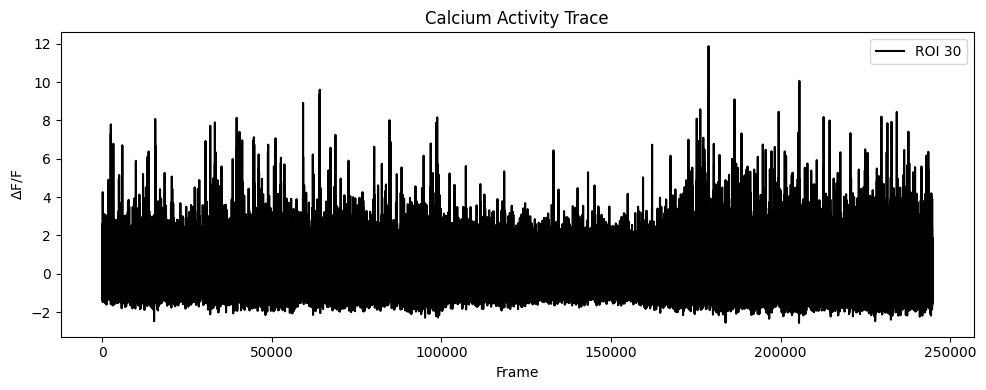

In [32]:
# Select an ROI 
ROI = 30

# Figure parameters 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons * 
    2. Spontaneous activity *
    3. BCI behavior task 
    4. Spontaneous activity * 
    5. Photostimulation of single neurons * 
    
*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

The NWB file contains information about the stimulus and the behavior trials.  


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Stimulus table (2p optogenetic activation stimulus) 
    
The stimulus table (stimulus > PhotostimTrials) contains information about each 2p optogenetic stimulation trial. 


| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stim_name    | stimulus name   |
| laser_stim_x    | x coordinate of stimulated neuron (pixel)   |
| laser_stim_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)*    |

*note that this number does not correspond to the image segmentation ROI index

In [33]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim


,start_time,stop_time,start_frame,stop_frame,tiff_file,stim_name,laser_stim_x,laser_stim_y,power,duration,stimulus_function,group_index
id,,,,,,,,,,,,
0,0.000000,0.652545,0,38,spont_slm_00001.tif,photostim,258.492308,27.107692,2,0.652545,scanimage.mroi.stimulusfunctions.logspiral,2
1,0.669718,1.270746,39,74,spont_slm_00002.tif,photostim,140.107143,140.285714,2,0.601029,scanimage.mroi.stimulusfunctions.logspiral,98
2,1.287918,1.923292,75,112,spont_slm_00003.tif,photostim,265.729730,215.324324,2,0.635373,scanimage.mroi.stimulusfunctions.logspiral,95
3,1.940464,2.524320,113,147,spont_slm_00004.tif,photostim,284.068182,111.272727,2,0.583856,scanimage.mroi.stimulusfunctions.logspiral,3
4,2.541492,3.194038,148,186,spont_slm_00005.tif,photostim,437.891304,145.413043,2,0.652545,scanimage.mroi.stimulusfunctions.logspiral,36
...,...,...,...,...,...,...,...,...,...,...,...,...
4405,4200.024405,4200.643122,244378,244414,spontpost_slm_02009.tif,photostim_post,437.891304,145.413043,2,0.618717,scanimage.mroi.stimulusfunctions.logspiral,36
4406,4200.660309,4201.244653,244415,244449,spontpost_slm_02010.tif,photostim_post,251.157895,244.421053,2,0.584344,scanimage.mroi.stimulusfunctions.logspiral,40
4407,4201.261839,4201.863370,244450,244485,spontpost_slm_02011.tif,photostim_post,148.741379,88.672414,2,0.601531,scanimage.mroi.stimulusfunctions.logspiral,70


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation epochs - one before and one after the BCI epoch. This is distinguished by the "stim_name" column. 

In [11]:
photostim.stim_name.unique()

array(['photostim', 'photostim_post'], dtype=object)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI Behavior Table 
    
Information about the BCI behavior trials can be found in the intervals > trials table. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| BCI_go_cue |  time of go cue relative to start time (s)   |
| BCI_trial_hit   |  boolean of whether trial was hit   |
| BCI_lick_l  | lick times (s)   |
| BCI_reward_time   | reward delivery time (s)   |
| BCI_threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| BCI_zaber_steps   | position of reward port  |
| BCI_movie_name    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |


In [34]:
bci = nwbfile.intervals["trials"].to_dataframe()
bci


,start_time,stop_time,BCI_go_cue,BCI_trial_hit,BCI_lick_L,BCI_reward_time,BCI_threshold_crossing_times,BCI_zaber_steps,BCI_movie_name,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y
id,,,,,,,,,,,,,
0,1713.935322,1723.966170,0.2359,True,"[3.8459, 3.9419, 4.0680000000000005, 4.4359, 4...",3.8459,3.6877,"[1.8148, 1.9748, 2.1048, 2.2708, 2.4148, 2.970...",neuron72_00001.tif,99786,100370,164.25,129.875
1,1723.983346,1731.059903,0.2359,True,"[1.8125, 2.1539, 2.2744, 2.4138, 2.6332, 2.777...",2.1539,1.9978,"[0.2869, 0.4689, 0.5839, 0.6569, 0.7239, 0.790...",neuron72_00002.tif,100371,100783,164.25,129.875
2,1731.077080,1739.682311,0.2359,True,"[3.1149, 3.2676000000000003, 3.4052, 3.657, 3....",3.2676,3.2089,"[0.6491, 1.635, 1.7080000000000002, 1.791, 1.8...",neuron72_00003.tif,100784,101285,164.25,129.875
3,1739.699487,1754.677055,0.2359,True,"[1.5375, 1.8692, 2.0268, 2.1422, 2.38880000000...",2.0268,1.9754,"[0.2865, 0.5875, 0.8194, 1.1524, 1.2394, 1.319...",neuron72_00004.tif,101286,102158,164.25,129.875
4,1754.694231,1761.461618,0.2359,True,"[0.0159, 0.6422, 0.7583000000000001, 0.9404, 1...",0.7583,0.7086,"[0.2871, 0.3231, 0.3551, 0.3871, 0.4191, 0.451...",neuron72_00005.tif,102159,102553,164.25,129.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2590.346339,2605.083442,0.2359,True,"[5.1549000000000005, 5.2653, 5.4058, 5.5411, 5...",5.1549,4.5467,"[0.287, 0.472, 1.0549, 1.3019, 1.7349, 2.1888,...",neuron72_00083.tif,150811,151669,164.25,129.875
83,2605.100618,2613.997843,0.2359,True,"[0.0676, 4.6426, 4.8207, 4.9914000000000005, 5...",5.0971,5.0296,"[0.3619, 0.6429, 0.8699, 1.5738, 1.8318, 2.093...",neuron72_00084.tif,151670,152188,164.25,129.875
84,2614.015019,2650.668838,0.2359,True,"[4.970400000000001, 5.0712, 5.192200000000001,...",4.9704,4.6834,"[0.2867, 0.5407000000000001, 0.763600000000000...",neuron72_00085.tif,152189,154323,164.25,129.875


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
We've written a helper function `generate_epoch_table` that will aggregate the start/end frames and times from the stimulus table and the behavior table from the nwb file. This generates a table with the start and stop times for each experimental epoch, so we can easily pull these values for later use. 


In [16]:
help(generate_epoch_table)

Help on function generate_epoch_table in module generate_epoch_table:

generate_epoch_table(nwbfile)
    Finds frame and time ranges for photostim, photostim_post, behavior, spontaneous, and spontaneous_post epochs from the photostim and behavior tables in the NWB files 
    
    Parameters:
    - nwbfile: NWBFile object
    
    Returns:
    - epoch_table: pandas.DataFrame of epoch frame and time ranges



In [35]:
epoch_table = generate_epoch_table(nwbfile)

epoch_table

,stim_name,start_frame,stop_frame,start_time,stop_time
1,photostim,0,87924,0.000000,1510.283096
3,spont,87925,99785,1510.300274,1714.021186
0,BCI,99786,157937,1714.038363,2712.906390
4,spont_post,157938,171137,2712.923567,2939.644674
2,photostim_post,171138,244734,2939.661851,4203.830846


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot calcium activity for a select ROI with stimulus epochs overlaid. 


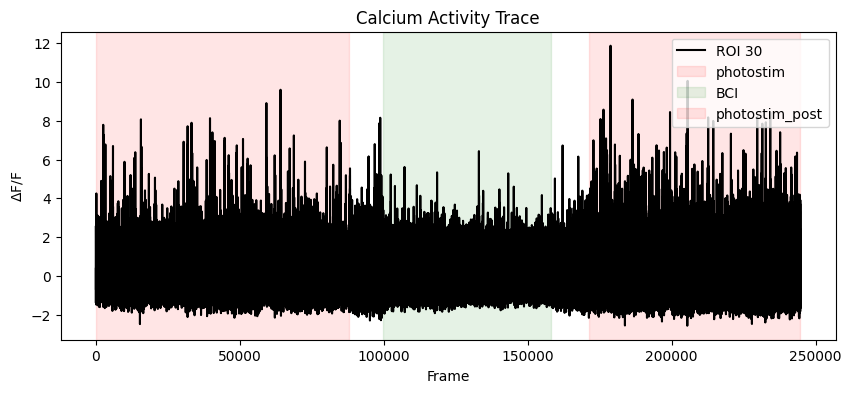

In [36]:
# Plot dff for select ROI 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image Segmentation Table 
    
Each column in dff contains change in fluorescence activity for an extracted ROI. The raw fluorescence data is run through suite2p, which segments the image to extract image masks for each detected ROI. The suite2p outputs are run through additional soma and dendrite classifiers. Information about the spatial image masks and soma/dendrite can be found in the image segmentation table within the processing container. 
    
We'll store the image segmentation table as a Pandas DataFrame. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

In [37]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,1,0.986149,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,1,0.999053,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,0.999999,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,0.999996,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0.078073,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
538,1,0.536435,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
539,1,0.999980,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
540,0,0.000923,0,0.000000e+00,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [38]:
len(image_segmentation[image_segmentation.is_soma==1])

474

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### ROI Image Masks 
    
The image masks for each ROI are necessary for corresponding the ROIs to the photostimulated and conditioned neurons. If you recall, the photostim and bci tables report the centroid coordinates in pixel space for the photostimulated and conditioned neurons in each trial. 

Text(0.5, 1.0, 'ROI Image Mask')

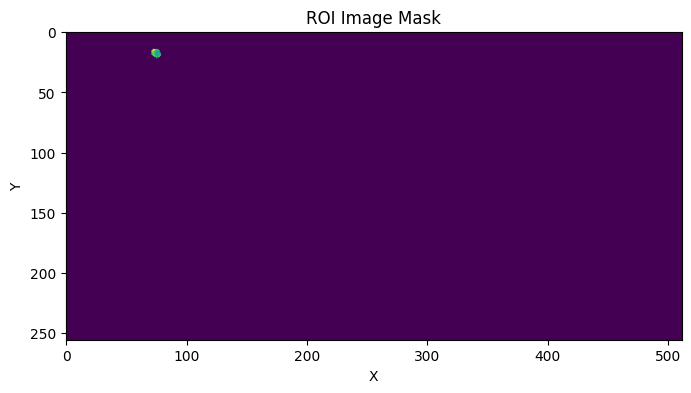

In [39]:
# Plot the image mask for selected ROI 
plt.imshow(image_segmentation.image_mask[ROI])
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('ROI Image Mask') 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot ROI DFF and Image Masks 
    
Building on our DFF frameseries plot, we'll add a plot indicating the spatial location of the selected ROI. Using image mask, we'll identify the contours of the ROI and overlay this with the average projection of the FOV image. 

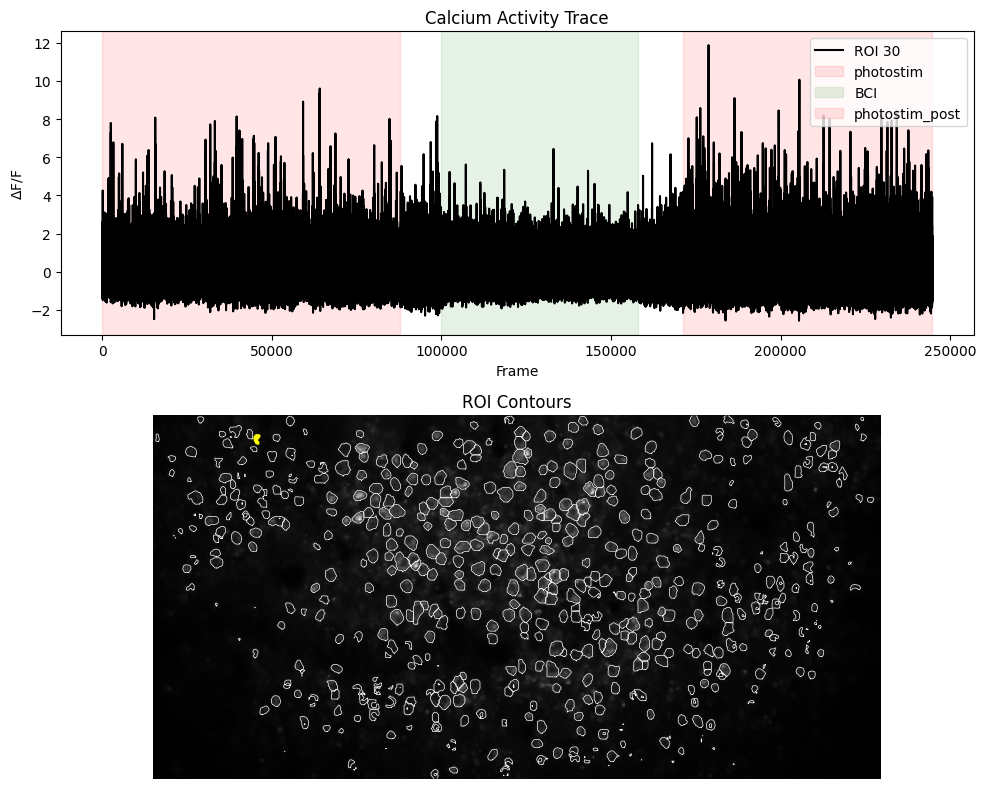

In [40]:
# FOV image data to underlay with image mask contours 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Figure parameters for vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top Plot: ROI DFF 
ax1.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Top Plot: Shaded regions for stimulus epochs 
stim_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stim_name in enumerate(stim_names):
    stim = epoch_table[epoch_table.stim_name==stim_name]
    for j in range(len(stim)):
        ax1.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stim_name)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(loc='upper right')

# Bottom plot: Grayscale image with ROI contours 
ax2.imshow(image, cmap='gray')
ax2.set_title('ROI Contours')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(image_segmentation.image_mask):
    mask_array = np.array(mask)
    contours = measure.find_contours(mask_array, level=0.3)
    for contour in contours:
        color = 'yellow' if i == ROI else 'white'
        linewidth = 2.0 if i == ROI else 0.5
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth)

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot conditioned neuron activity and behavior events 

During the BCI behavior epoch, the activity of a single neuron (conditioned neuron) is used to control the movement of a reward lickport. Using information from the bci table and the image segmentation table, let's walk through how to plot the activity of the conditioned neuron aligned to the behavior trial start, lickport movements, and reward times. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### 1. Match the conditioned neuron to an extracted ROI 

The centroid coordinates of the conditioned neuron are reported in the `conditioned_neuron_x` and `conditioned_neuron_y` columns of the bci table. 

In [41]:
print('Conditioned neuron coordinates:', bci.conditioned_neuron_x[0], bci.conditioned_neuron_y[0])

Conditioned neuron coordinates: 164.25000000244444 129.87500000008149


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Using the image masks, we need to find the ROI that is closest to the conditioned neuron coordinate.     
    
The `get_roi_centroids` function will calculate the centroid for each ROI image mask in the image segmentation table. This finds the x,y indices for each mask and calculates the mean to get the center. 

In [20]:
def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

In [21]:
def add_roi_centroids(segmentation):
    centroids = []
    segmentation_df = segmentation.copy()
    for mask in segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    centroids = np.array(centroids)
    segmentation_df['x'] = centroids[:,0]
    segmentation_df['y'] = centroids[:,1]
    return segmentation_df

In [42]:
image_segmentation = add_roi_centroids(image_segmentation)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">

I'd recommend addign this back to the image_segmentation dataframe rather than making a new array.
    
This can be neater, but it does it. 
    
(Also, it's not great to use the same name of a global variable as a local variable. it makes functions prone to problems that are hard to detect) 

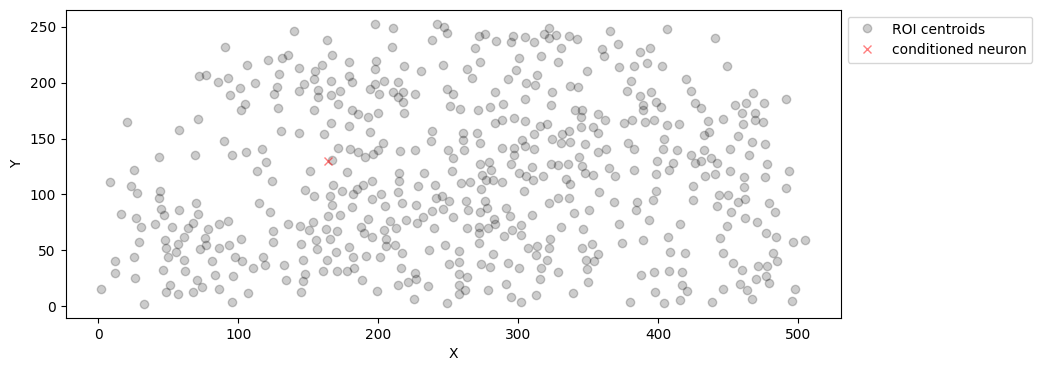

In [43]:
# Plot ROI centroids (black) and conditioned neuron coordinate (red) 

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.plot(bci['conditioned_neuron_x'].dropna().iloc[0], bci['conditioned_neuron_y'].dropna().iloc[0], 'rx', alpha = 0.5, label = 'conditioned neuron')
# plt.plot(bci['conditioned_neuron_x'].dropna().iloc[0]*2, bci['conditioned_neuron_y'].dropna().iloc[0]*2, 'gx', alpha = 0.5, label = 'conditioned neuron')
plt.xlabel('X') 
plt.ylabel('Y')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">

comment says red, but code says green.
I also think a red x is more effective to show the overlay
Need to make sure the plot stays the right shape. (index=26 is square FOV but the plot is elongated)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We'll find the extracted ROI centroid that is closest to the conditioned neuron coordinate 

In [44]:
# Grab the first non-null entry
x = bci['conditioned_neuron_x'].dropna().iloc[0]
y = bci['conditioned_neuron_y'].dropna().iloc[0]
conditioned_coord = np.array([x, y])
print("Conditioned neuron coordinate:", conditioned_coord)

# Get centroids and match
centroids = get_roi_centroids(image_segmentation)
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1)) # Calculate euclidean distance between each ROI coord and conditioend neuron coord, find min 
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")


Conditioned neuron coordinate: [164.25  129.875]
Closest ROI is #316 at [166.88461538 130.48076923]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">

Might be worth adding a distance function since we use that for the photostim stuff too? I might be easier to use the dataframe but it doesn't seem to be much faster

In [25]:
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask,x,y
id,,,,,,,
0,0,0.031965,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",71.222222,2.777778
1,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",97.326531,2.959184
2,1,0.999939,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",176.097561,3.390244
3,0,0.199752,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",157.250000,3.500000
4,1,1.000000,0,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",455.750000,4.636364


In [26]:
np.linalg.norm(np.array([image_segmentation.x, image_segmentation.y]).T - conditioned_coord, axis=1)

array([300.38591148, 281.41049899, 232.78064938, 242.80644395,
       256.44548966, 213.4915004 , 250.05317351, 198.6198576 ,
       215.50516418, 345.22026738, 241.35325885, 194.79164723,
       230.19864764, 260.25941381, 267.36387779, 321.75350864,
       193.6604154 , 262.19314688, 194.21094574, 276.15501414,
       295.12487258, 242.09600759, 195.62132074, 336.53556201,
       325.23619576, 273.85825148, 211.93169387, 189.55481846,
       227.21227076, 238.97000762, 251.67057172, 213.71929712,
       242.62175588, 237.80294243, 283.7587677 , 255.20568279,
       228.40861057, 198.51966093, 269.78156002, 247.12611665,
       188.77977747, 193.55729595, 181.783454  , 205.59531231,
       179.5030935 , 330.6710098 , 295.63183679, 266.1842616 ,
       222.58790177, 179.40477787, 198.26972119, 227.79533279,
       211.76705026, 207.50647932, 178.86419087, 175.76408992,
       199.71003964, 204.8094404 , 211.71897705, 282.72837194,
       217.98330382, 177.25225127, 236.14253158, 241.33

In [27]:
np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1))

np.int64(528)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">

No need to recompute the centroids

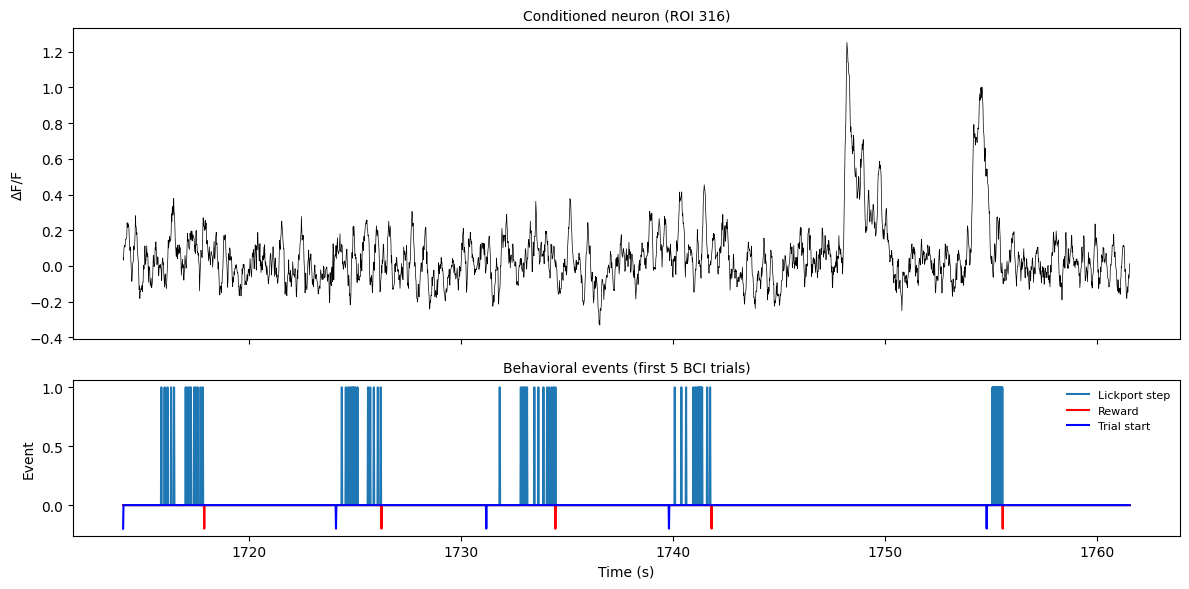

In [47]:
# Plot conditioned neuron DFF alongside behavior events 

# Set smoothing window size (in frames); set to 0 to disable smoothing
smoothing_window = 10

# Build binary time series
n_frames = dff.shape[0]
lickport_steps_ts = np.zeros(n_frames)
rewards_ts = np.zeros(n_frames)
trial_starts_ts = np.zeros(n_frames)

# If behavior event happened, set timeseries index == 1 
for _, row in bci.iterrows():
    trial_start_f = int(row['start_frame'])

    # Trial start
    if trial_start_f < n_frames:
        trial_starts_ts[trial_start_f] = 1

    # Reward
    rt = row.get('BCI_reward_time', np.nan)
    if not np.isnan(rt):
        reward_f = trial_start_f + int(rt * frame_rate)
        if reward_f < n_frames:
            rewards_ts[reward_f] = 1

    # Zaber steps
    zsteps = row.get('BCI_zaber_steps', [])
    if isinstance(zsteps, (list, np.ndarray)):
        for tstep in zsteps:
            if not np.isnan(tstep):
                step_f = trial_start_f + int(tstep * frame_rate)
                if 0 <= step_f < n_frames:
                    lickport_steps_ts[step_f] = 1

# Define frame range for first 5 trials
start_f = int(bci['start_frame'].iloc[0])
stop_f  = int(bci['stop_frame'].iloc[4])

frame_range = slice(start_f, stop_f)
t = np.arange(start_f, stop_f) / frame_rate

# Plot stacked subplots 
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, height_ratios=[1, 0.5])

# Plot conditioned neuron activity over frame_range
trace = dff[frame_range, conditioned_neuron]

# Apply boxcar smoothing if requested
if smoothing_window > 0:
    kernel = np.ones(smoothing_window) / smoothing_window
    trace = np.convolve(trace, kernel, mode='same')

axs[0].plot(t, trace, 'k', linewidth=0.5)

axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=10)

# Plot behavioral events 
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=8, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=10)

plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #FAF0FF; ">
Break this code into two pieces. One which takes the discrete events to make a continuous variable, a second one to make the plot.